In [1]:
import pandas as pd
import json

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('kaiser_data_map.csv', parse_dates = ['Message Date'])
df.head(3)

,Account Id,Message Date,Message Name,Number of Records,Preference Type
0,1057,2016-03-17,1,72,KP Education
1,1057,2016-03-26,1 day After Surgery Care,5,Care Continuum
2,1057,2016-03-25,1 day After Surgery Care,15,Care Continuum


In [3]:
# Simple stats 
print 'Unique Preference Types: ', list(df['Preference Type'].unique())
print '------------------------------------------------------------------'
print 'Unique Account Ids: ', list(df['Account Id'].unique())

Unique Preference Types:  ['KP Education', 'Care Continuum', 'Visit X', 'Chronic Disease Management', 'MNP']
------------------------------------------------------------------
Unique Account Ids:  [1057, 1031, 1075]


In [4]:
# Select columns needed for calendar view
df = df[['Message Date', 'Number of Records', 'Preference Type']]
df.head(3)

,Message Date,Number of Records,Preference Type
0,2016-03-17,72,KP Education
1,2016-03-26,5,Care Continuum
2,2016-03-25,15,Care Continuum


In [29]:
# Extract month from date
print df['Message Date'][0].month
df['month'] = df['Message Date'].apply(lambda d: d.month)
df['year'] = df['Message Date'].apply(lambda d: d.year)
df.head(3)

3


,Message Date,Number of Records,Preference Type,month,year
0,2016-03-17,72,KP Education,3,2016
1,2016-03-26,5,Care Continuum,3,2016
2,2016-03-25,15,Care Continuum,3,2016


In [30]:
# Rename columns
cols = ['date', 'num_records', 'pref_type', 'month', 'year']
df.columns = cols
df.head(3)

,date,num_records,pref_type,month,year
0,2016-03-17,72,KP Education,3,2016
1,2016-03-26,5,Care Continuum,3,2016
2,2016-03-25,15,Care Continuum,3,2016


In [31]:
# Create dataframe after filtering by month and year
jan_data = df[(df['month'] == 1) & (df['year'] == 2016)][['date', 'num_records', 'pref_type']]
feb_data = df[(df['month'] == 2) & (df['year'] == 2016)][['date', 'num_records', 'pref_type']]
mar_data = df[(df['month'] == 3) & (df['year'] == 2016)][['date', 'num_records', 'pref_type']]

In [32]:
# Get data for feb
feb_data.reset_index(inplace = True)
del feb_data['index']
feb_data.head(3)

,date,num_records,pref_type
0,2016-02-25,1,Care Continuum
1,2016-02-23,1,Care Continuum
2,2016-02-29,1,Care Continuum


In [33]:
list(feb_data['date'].unique())

[numpy.datetime64('2016-02-24T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-22T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-28T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-23T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-21T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-27T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-26T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-25T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-19T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-17T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-10T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-18T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-04T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-02T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-16T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-15T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-07T16:00:00.000000000-0800'),
 numpy.datetime64('2016-02-14T1

In [34]:
# Create a temporary dataframe to concatenate with month data
pref_type = ['KP Education', 'Care Continuum', 'Visit X', 'Chronic Disease Management', 'MNP']
df_temp = pd.DataFrame()
for d in list(feb_data['date'].unique()):
    for i in pref_type:
        temp = pd.DataFrame({'date': [d], 'num_records': [0],'pref_type': [i]})
        df_temp = pd.concat([df_temp, temp])
    
print df_temp.shape[0]
df_temp.head(3)

145


,date,num_records,pref_type
0,2016-02-25,0,KP Education
0,2016-02-25,0,Care Continuum
0,2016-02-25,0,Visit X


In [35]:
# Concatenate temp dataframe to month data
feb_data = pd.concat([feb_data, df_temp])
print feb_data.shape[0]

298


In [36]:
# Group data by date and preference type
calendar_data = feb_data.groupby(['date','pref_type'], as_index = False).sum()
calendar_data.head()

,date,pref_type,num_records
0,2016-02-01,Care Continuum,0
1,2016-02-01,Chronic Disease Management,0
2,2016-02-01,KP Education,0
3,2016-02-01,MNP,0
4,2016-02-01,Visit X,86


In [37]:
# Write a *.tsv file
calendar_data.to_csv('data.tsv', sep = '\t', index = False)

In [38]:
temp_df = pd.DataFrame({'date': list(calendar_data['date'].unique())})
temp_df.shape[0]

29

In [39]:
temp_df = pd.DataFrame({'date': list(calendar_data['date'].unique())})
for i, j in enumerate(pref_type):
    print 'Preference Type: ', j
    temp = calendar_data[calendar_data['pref_type'] == j]
    temp_cols = ['date', str(i), j]
    temp.columns = temp_cols
    del temp[str(i)]
    temp_df = pd.merge(temp_df, temp, how = 'inner', on = 'date')

# Sum the columns to get total
temp_df['Total'] = temp_df.sum(axis = 1)
print 'Number of Days: ', temp_df.shape[0]
print 'Temporary Dataframe Columns: ', list(temp_df.columns.values)
temp_df.head(3)

Preference Type:  KP Education
Preference Type:  Care Continuum
Preference Type:  Visit X
Preference Type:  Chronic Disease Management
Preference Type:  MNP
Number of Days:  29
Temporary Dataframe Columns:  ['date', 'KP Education', 'Care Continuum', 'Visit X', 'Chronic Disease Management', 'MNP', 'Total']


,date,KP Education,Care Continuum,Visit X,Chronic Disease Management,MNP,Total
0,2016-02-01,0,0,86,0,0,86
1,2016-02-02,0,0,92,0,0,92
2,2016-02-03,0,45,140,0,0,185


In [40]:
temp_df.describe()

,KP Education,Care Continuum,Visit X,Chronic Disease Management,MNP,Total
count,29.000000,29.000000,29.000000,29,29,29.000000
mean,329.586207,2448.620690,273.965517,0,0,3052.172414
std,570.343914,11008.971859,153.475797,0,0,11073.592503
min,0.000000,0.000000,36.000000,0,0,79.000000
25%,1.000000,0.000000,94.000000,0,0,185.000000
50%,309.000000,3.000000,341.000000,0,0,682.000000
75%,362.000000,50.000000,385.000000,0,0,757.000000
max,3178.000000,58594.000000,515.000000,0,0,59440.000000


In [41]:
# Write a *.tsv file
temp_df.to_csv('calendar.tsv', sep = '\t', index = False)

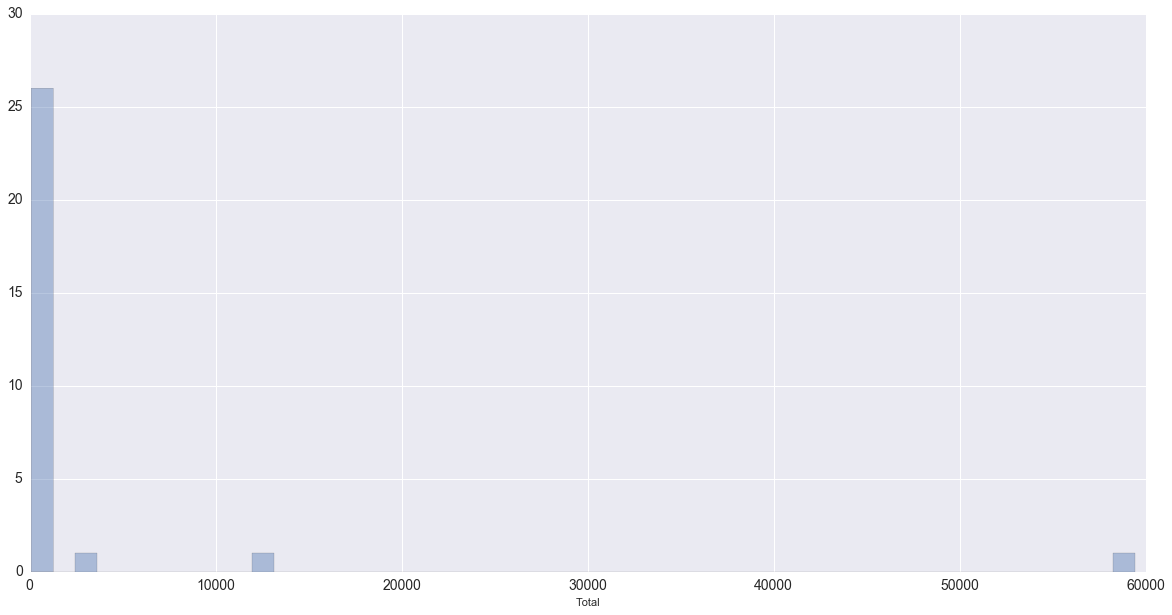

In [42]:
# Histogram
plt.figure(figsize = (20, 10))
sns.distplot(temp_df['Total'], kde = False)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

### Change data structure to JSON

In [43]:
temp = feb_data.copy()
temp.head(3)

,date,num_records,pref_type
0,2016-02-25,1,Care Continuum
1,2016-02-23,1,Care Continuum
2,2016-02-29,1,Care Continuum


In [44]:
# Convert datetime to string
temp['date'] = temp['date'].apply(lambda d: d.strftime('%Y-%m-%d'))

In [45]:
grouped = temp.groupby(['date','pref_type'], as_index = True).sum()
grouped.head(5)

num_records
date       pref_type                              
2016-02-01 Care Continuum                        0
           Chronic Disease Management            0
           KP Education                          0
           MNP                                   0
           Visit X                              86

In [47]:
# Creating json of grouped by object
from collections import defaultdict

results = defaultdict(lambda: defaultdict(dict))

for index, value in grouped.itertuples():
    for i, key in enumerate(index):
        if i == 0:
            nested = results[key]
        elif i == len(index) - 1:
            nested[key] = value
        else:
            nested = nested[key]

# Print json
#print json.dumps(results, indent = 4)